In [1]:
# Import Libraries
import numpy as np
import h5py
import gc
import librosa
import os
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import librosa
import os
from collections import Counter
from tensorflow.keras.models import load_model

# Clear Session
K.clear_session()
gc.collect()

0

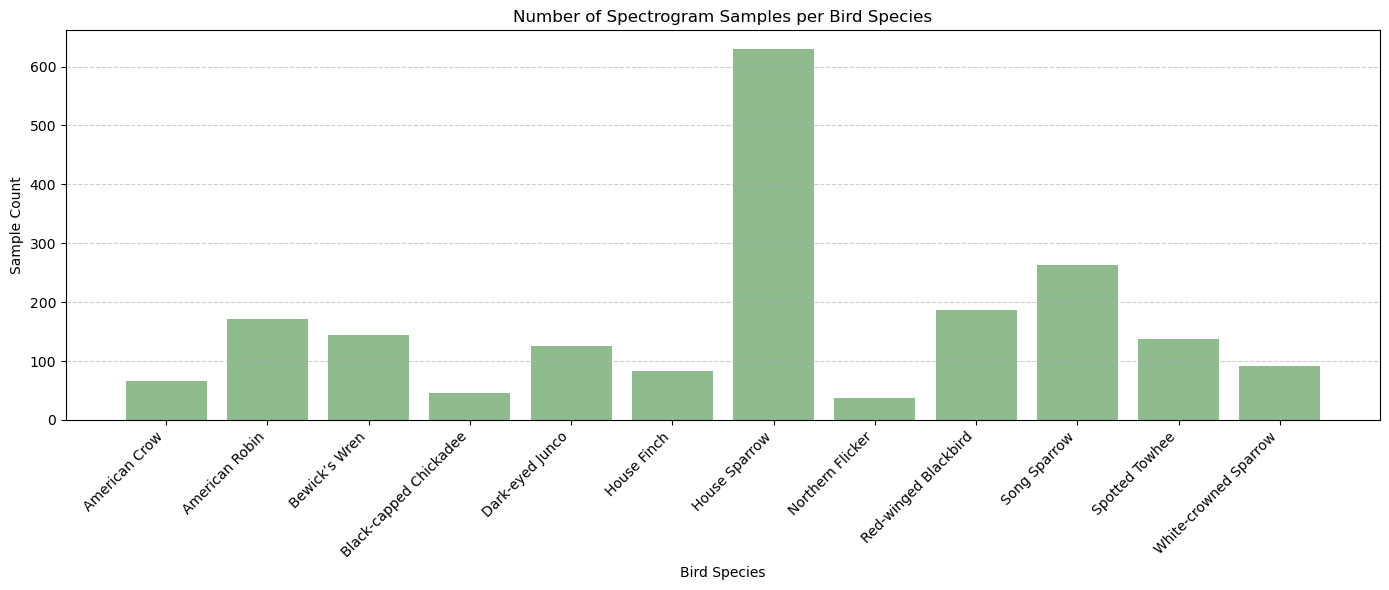

In [2]:
# Mapping from short code to full species name
species_fullnames = {
    'amecro': 'American Crow',
    'amerob': 'American Robin',
    'bewwre': "Bewick’s Wren",
    'bkcchi': 'Black-capped Chickadee',
    'daejun': 'Dark-eyed Junco',
    'houfin': 'House Finch',
    'houspa': 'House Sparrow',
    'norfli': 'Northern Flicker',
    'rewbla': 'Red-winged Blackbird',
    'sonspa': 'Song Sparrow',
    'spotow': 'Spotted Towhee',
    'whcspa': 'White-crowned Sparrow'
}

# Load Data
f = h5py.File('bird_spectrograms.hdf5', 'r')
species_keys = list(f.keys())
species_counts = {key: f[key].shape[2] for key in species_keys}

# Map codes to full names (keeping same order)
species_labels = [species_fullnames[key] for key in species_keys]
counts = [species_counts[key] for key in species_keys]

# Plot
plt.figure(figsize=(14, 6))
plt.bar(species_labels, counts, color='darkseagreen')
plt.title("Number of Spectrogram Samples per Bird Species")
plt.xlabel("Bird Species")
plt.ylabel("Sample Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Binary Classifier

In [4]:
# Transpose and load data
bird1 = np.transpose(f['amerob'][:], (2, 0, 1))  
bird2 = np.transpose(f['rewbla'][:], (2, 0, 1))  

# Add channel dimension
bird1 = bird1[..., np.newaxis]  
bird2 = bird2[..., np.newaxis]

# Combine dataset
X = np.concatenate([bird1, bird2], axis=0)
y = np.concatenate([np.zeros(len(bird1)), np.ones(len(bird2))])

# Normalize per sample
X = (X - np.min(X, axis=(1, 2, 3), keepdims=True)) / (
     np.max(X, axis=(1, 2, 3), keepdims=True) - np.min(X, axis=(1, 2, 3), keepdims=True) + 1e-6
)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Define CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Final accuracy\
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal validation accuracy: {final_val_acc:.4f}")

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.4809 - auc: 0.4737 - loss: 5.5210 - precision: 0.4967 - recall: 0.5140 - val_accuracy: 0.5333 - val_auc: 0.5072 - val_loss: 0.8464 - val_precision: 0.5281 - val_recall: 1.0000
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.5812 - auc: 0.5661 - loss: 0.8845 - precision: 0.6144 - recall: 0.6201 - val_accuracy: 0.5333 - val_auc: 0.6037 - val_loss: 0.7023 - val_precision: 0.8571 - val_recall: 0.1277
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.7349 - auc: 0.7887 - loss: 0.6480 - precision: 0.7821 - recall: 0.6734 - val_accuracy: 0.5778 - val_auc: 0.5950 - val_loss: 0.6919 - val_precision: 0.6216 - val_recall: 0.4894
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.7104 - auc: 0.7844 - loss: 0.6100 - precision: 0.7482 - recall: 0.6754 - val_accuracy: 0.6889 - val_auc: 0.7830 - val_loss: 0.5912 - val_precision: 0.6792 - val_recall: 0.7660
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step -

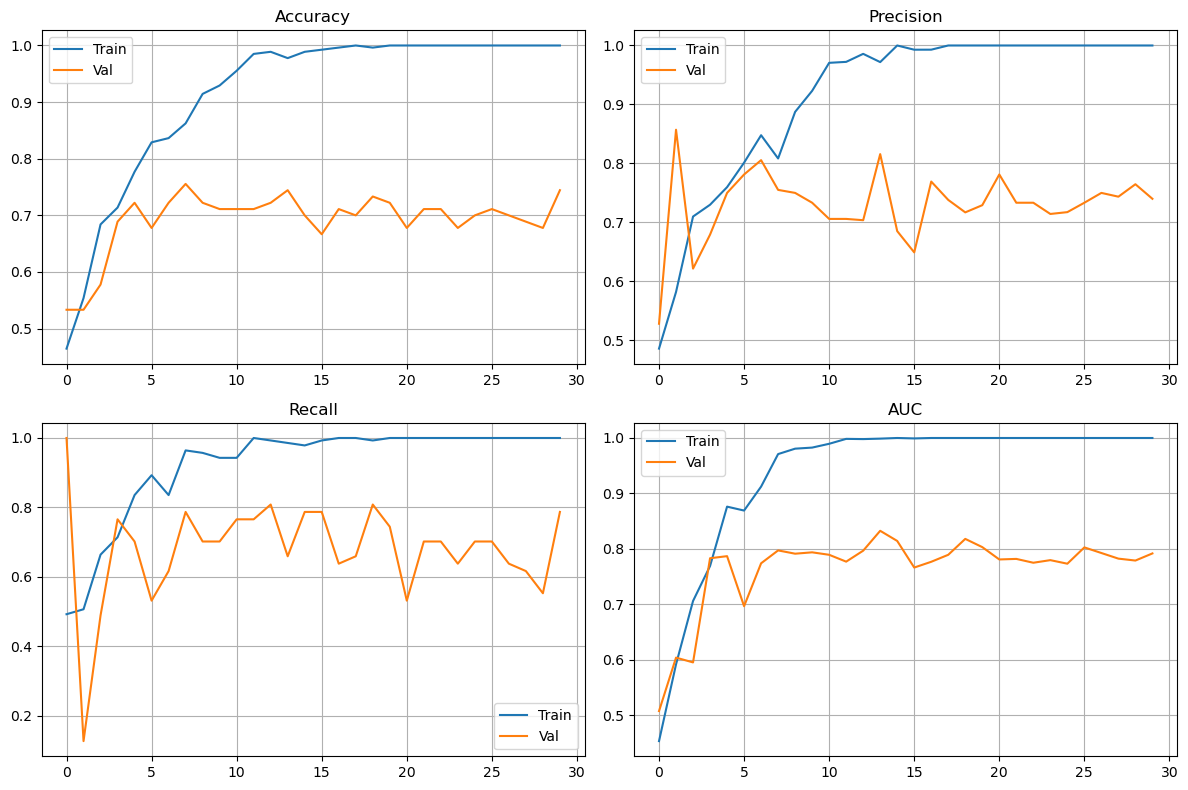

In [5]:
# Plots
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(history.history['precision'], label='Train')
plt.plot(history.history['val_precision'], label='Val')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.title('Recall')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Val')
plt.title('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
#Early Stopping
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Print Validation Accuracy
final_val_acc = history.history['val_accuracy'][-1]
print(f"\n Final validation accuracy: {final_val_acc:.4f}")

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0016 - precision: 1.0000 - recall: 1.0000

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0016 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.6889 - val_auc: 0.7956 - val_loss: 0.9671 - val_precision: 0.7209 - val_recall: 0.6596
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 8.7625e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7000 - val_auc: 0.7875 - val_loss: 1.0473 - val_precision: 0.7500 - val_recall: 0.6383
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 7.5201e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7444 - val_auc: 0.8043 - val_loss: 0.9825 - val_precision: 0.7609 - val_recall: 0.7447
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 6.7950e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7444 - val_auc: 0.7961 - val_loss: 1.0282 - val_precision: 0.7727 - val_recall: 0.7234
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 

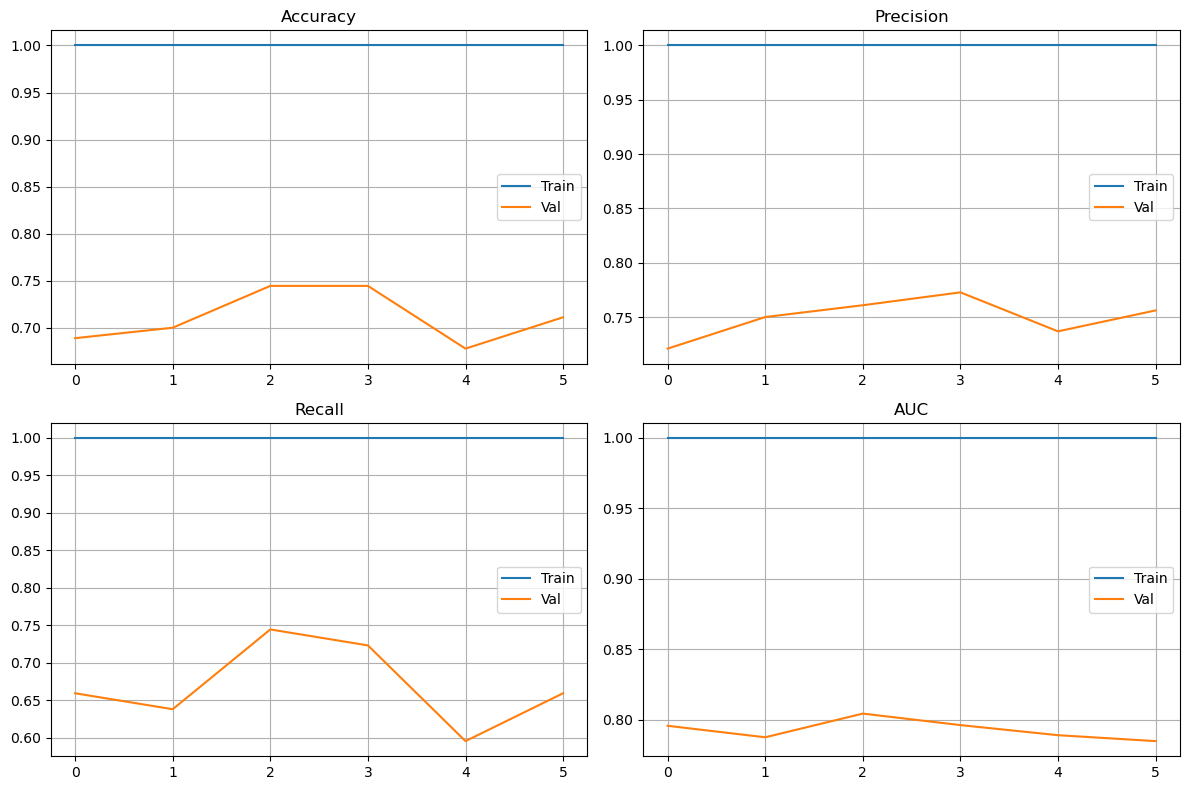

In [7]:
# Plots
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(history.history['precision'], label='Train')
plt.plot(history.history['val_precision'], label='Val')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.title('Recall')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Val')
plt.title('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Clear previous models from memory
K.clear_session()
gc.collect()

0

In [9]:
# Normalize X 
X = (X - X.min(axis=(1, 2, 3), keepdims=True)) / (X.max(axis=(1, 2, 3), keepdims=True) - X.min(axis=(1, 2, 3), keepdims=True) + 1e-6)

# Split and Encode Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train).flatten()
y_test = lb.transform(y_test).flatten()

# Define CNN
model1 = Sequential()
model1.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(8, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(Flatten())
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='sigmoid'))

#Compile the Model
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

history = model1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test, y_test)
)

# Print Validation Accuracy
print(f"\nFinal validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.4814 - auc: 0.5223 - loss: 1.3088 - precision: 0.5360 - recall: 0.4531 - val_accuracy: 0.4778 - val_auc: 0.5972 - val_loss: 0.7280 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6556 - auc: 0.7316 - loss: 0.6687 - precision: 0.6238 - recall: 0.6347 - val_accuracy: 0.4778 - val_auc: 0.7073 - val_loss: 0.7529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.8005 - auc: 0.8351 - loss: 0.5047 - precision: 0.8307 - recall: 0.7661 - val_accuracy: 0.4778 - val_auc: 0.7437 - val_loss: 0.6926 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.7667 - auc: 0.8757 - loss: 0.4385 - precision: 0.8227 - recall: 0.7346 - val_accuracy: 0.4778 - val_auc: 0.7190 - val_loss: 0.7154 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30


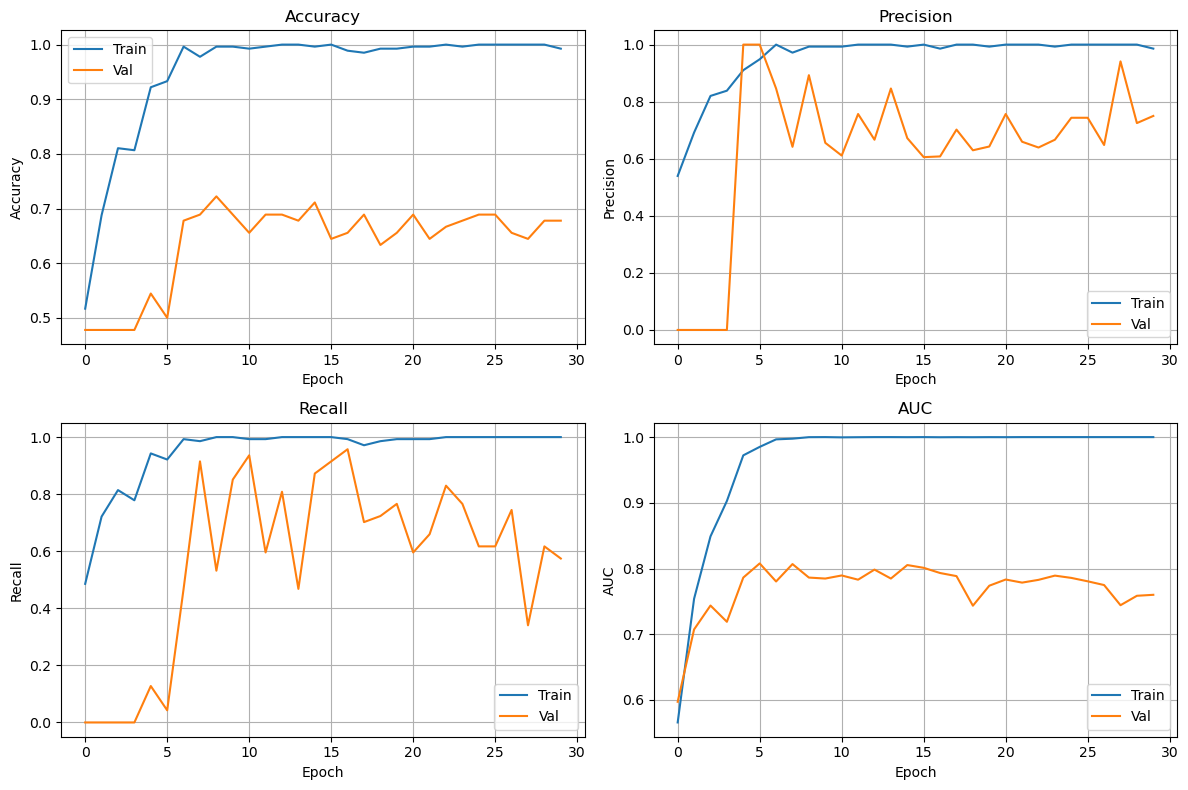

In [10]:
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(history.history['precision'], label='Train')
plt.plot(history.history['val_precision'], label='Val')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Val')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Multi-Class Classifier

In [12]:
# Clear Session
K.clear_session()
gc.collect()

0

In [ ]:
# Load Subset of Data
X = []
y = []

for species in species_keys:
    data = f[species][:]                   
    data = np.transpose(data, (2, 0, 1))     
    data = data[:300]                        
    data = data[..., np.newaxis]             
    X.append(data)
    y.extend([species] * data.shape[0])

# Combine and Normalize 
X = np.concatenate(X, axis=0)
y = np.array(y)

X = (X - np.min(X, axis=(1, 2, 3), keepdims=True)) / (
    np.max(X, axis=(1, 2, 3), keepdims=True) - np.min(X, axis=(1, 2, 3), keepdims=True) + 1e-6
)

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=len(species_keys))

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.25, stratify=y_cat, random_state=42
)

# Define multi-class CNN Model
model_multiclass = Sequential()

model_multiclass.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1)))
model_multiclass.add(BatchNormalization())
model_multiclass.add(MaxPooling2D((2, 2)))

model_multiclass.add(Conv2D(32, (3, 3), activation='relu'))
model_multiclass.add(BatchNormalization())
model_multiclass.add(MaxPooling2D((2, 2)))

model_multiclass.add(Conv2D(64, (3, 3), activation='relu'))
model_multiclass.add(BatchNormalization())
model_multiclass.add(MaxPooling2D((2, 2)))

model_multiclass.add(GlobalAveragePooling2D())
model_multiclass.add(Dense(64, activation='relu'))
model_multiclass.add(Dense(len(species_keys), activation='softmax'))

# Compile the Model
model_multiclass.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model
history = model_multiclass.fit(
    X_train, y_train,
    epochs=40,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

# Print Validation Accuracy
loss, acc = model_multiclass.evaluate(X_test, y_test)
print(f"\n Subset test accuracy: {acc:.4f}")

Epoch 1/40


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.1447 - loss: 2.4552 - val_accuracy: 0.1816 - val_loss: 2.4062
Epoch 2/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.1943 - loss: 2.2821 - val_accuracy: 0.1816 - val_loss: 2.3874
Epoch 3/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.2008 - loss: 2.2885 - val_accuracy: 0.1816 - val_loss: 2.4144
Epoch 4/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.2453 - loss: 2.2389 - val_accuracy: 0.1695 - val_loss: 2.5529
Epoch 5/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.2298 - loss: 2.2381 - val_accuracy: 0.1235 - val_loss: 2.6778
Epoch 6/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.2824 - loss: 2.1683 - val_accuracy: 0.1259 - val_loss: 2.6777
Epoch 7/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.2531 - loss: 2.1953 - val_accuracy: 0.1598 - val_loss: 2.5781
Epoch 8/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.2789 - loss: 2.1389 - val_accuracy: 0.186

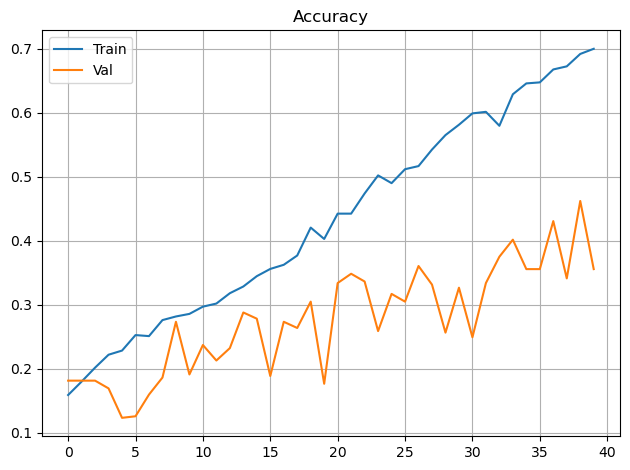

In [ ]:
# Plot

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
X = []
y = []

for species in species_keys:
    data = f[species][:]                      
    data = np.transpose(data, (2, 0, 1))      
    data = data[..., np.newaxis]              
    X.append(data)
    y.extend([species] * data.shape[0])

# Combine and  Normalize 
X = np.concatenate(X, axis=0)
y = np.array(y)
X = (X - np.min(X, axis=(1, 2, 3), keepdims=True)) / (
    np.max(X, axis=(1, 2, 3), keepdims=True) - np.min(X, axis=(1, 2, 3), keepdims=True) + 1e-6
)

# Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=len(species_keys))

# Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.25, stratify=y_cat, random_state=42
)

# Define the Model
model_multiclass_full1 = Sequential()
model_multiclass_full1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 517, 1)))
model_multiclass_full1.add(BatchNormalization())
model_multiclass_full1.add(MaxPooling2D((2, 2)))

model_multiclass_full1.add(Conv2D(64, (3, 3), activation='relu'))
model_multiclass_full1.add(BatchNormalization())
model_multiclass_full1.add(MaxPooling2D((2, 2)))

model_multiclass_full1.add(Conv2D(128, (3, 3), activation='relu'))
model_multiclass_full1.add(BatchNormalization())
model_multiclass_full1.add(MaxPooling2D((2, 2)))

model_multiclass_full1.add(GlobalAveragePooling2D())
model_multiclass_full1.add(Dense(128, activation='relu'))
model_multiclass_full1.add(Dropout(0.4))
model_multiclass_full1.add(Dense(len(species_keys), activation='softmax'))

# Compile the Model
model_multiclass_full1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model
history_full = model_multiclass_full1.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Print Validation Accuracy
loss, acc = model_multiclass_full1.evaluate(X_test, y_test)
print(f"\n Full dataset test accuracy: {acc:.4f}")

Epoch 1/40


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 47s 988ms/step - accuracy: 0.2464 - loss: 2.4104 - val_accuracy: 0.3185 - val_loss: 2.3780
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 965ms/step - accuracy: 0.2856 - loss: 2.2642 - val_accuracy: 0.3185 - val_loss: 2.3044
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 946ms/step - accuracy: 0.3168 - loss: 2.1894 - val_accuracy: 0.3185 - val_loss: 2.3264
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.3013 - loss: 2.1943 - val_accuracy: 0.3185 - val_loss: 2.3476
Epoch 5/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 927ms/step - accuracy: 0.3245 - loss: 2.1575 - val_accuracy: 0.0685 - val_loss: 2.5669
Epoch 6/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 947ms/step - accuracy: 0.3396 - loss: 2.1272 - val_accuracy: 0.0766 - val_loss: 2.8173
Epoch 7/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.3491 - loss: 2.0810 - val_accuracy: 0.0746 - val_loss: 2.7635
Epoch 8/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 931ms/step - accuracy: 0.3401 - loss: 2.0535 - val_accuracy: 0.1270 - v

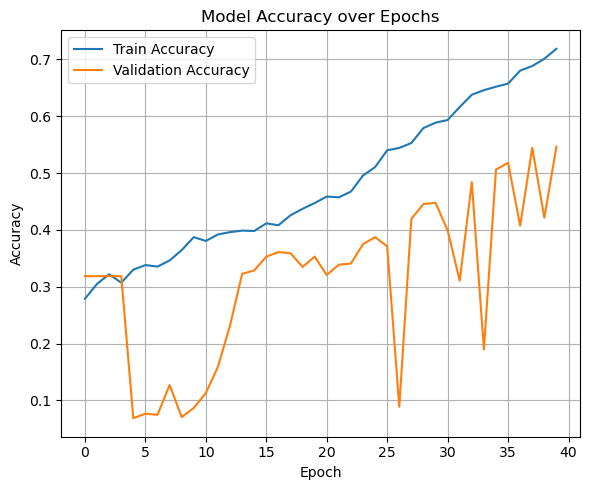

In [ ]:
#Plot

plt.figure(figsize=(6, 5))
plt.plot(history_full.history['accuracy'], label='Train Accuracy')
plt.plot(history_full.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Clear Session
K.clear_session()
gc.collect()

0

In [ ]:
# Add EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Define the Model
model_multiclass_full2 = Sequential()
model_multiclass_full2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 517, 1)))
model_multiclass_full2.add(BatchNormalization())
model_multiclass_full2.add(MaxPooling2D((2, 2)))

model_multiclass_full2.add(Conv2D(64, (3, 3), activation='relu'))
model_multiclass_full2.add(BatchNormalization())
model_multiclass_full2.add(MaxPooling2D((2, 2)))

model_multiclass_full2.add(Conv2D(128, (3, 3), activation='relu'))
model_multiclass_full2.add(BatchNormalization())
model_multiclass_full2.add(MaxPooling2D((2, 2)))

model_multiclass_full2.add(GlobalAveragePooling2D())
model_multiclass_full2.add(Dense(128, activation='relu'))
model_multiclass_full2.add(Dropout(0.4))
model_multiclass_full2.add(Dense(len(species_keys), activation='softmax'))

# Compile the Model
model_multiclass_full2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model
history_full = model_multiclass_full2.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Print Validation Accuracy
loss, acc = model_multiclass_full2.evaluate(X_test, y_test)
print(f"\n Full dataset test accuracy: {acc:.4f}")

Epoch 1/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.2200 - loss: 2.5037 - val_accuracy: 0.0867 - val_loss: 2.3593
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2739 - loss: 2.3112 - val_accuracy: 0.2056 - val_loss: 2.2553
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.3199 - loss: 2.1773 - val_accuracy: 0.2681 - val_loss: 2.2855
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3191 - loss: 2.1570 - val_accuracy: 0.3206 - val_loss: 2.2692
Epoch 5/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.3128 - loss: 2.1842 - val_accuracy: 0.3185 - val_loss: 2.4346
Epoch 6/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.3296 - loss: 2.1629 - val_accuracy: 0.3185 - val_loss: 2.4954
Epoch 7/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2668 - loss: 2.2171 - val_accuracy: 0.3185 - val_loss: 2.3477
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms

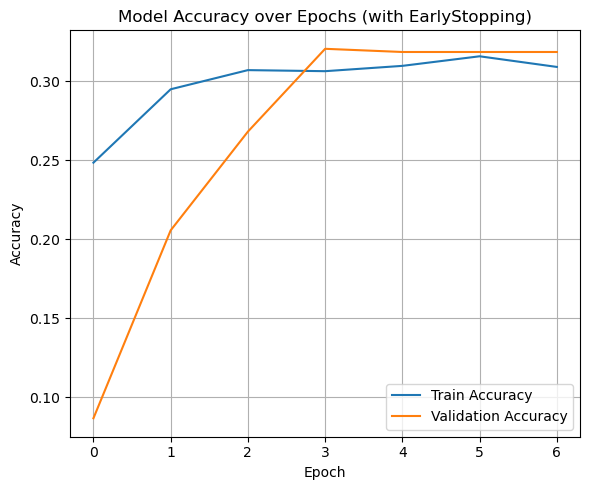

In [ ]:
#Plot

plt.figure(figsize=(6, 5))
plt.plot(history_full.history['accuracy'], label='Train Accuracy')
plt.plot(history_full.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (with EarlyStopping)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### External Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
test1.mp3: Predicted species: ['Song Sparrow', 'Dark-eyed Junco']
Multiple species likely present.


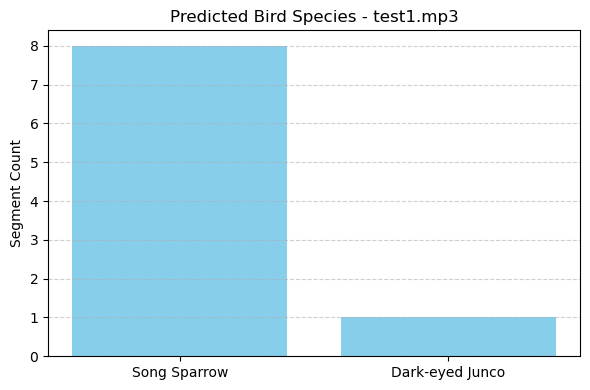

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
test2.mp3: Predicted species: ['Song Sparrow']
Single species likely present.


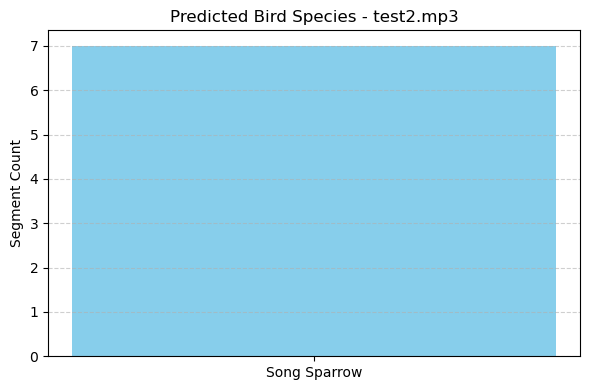

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
test3.mp3: Predicted species: ['Song Sparrow', 'Dark-eyed Junco']
Multiple species likely present.


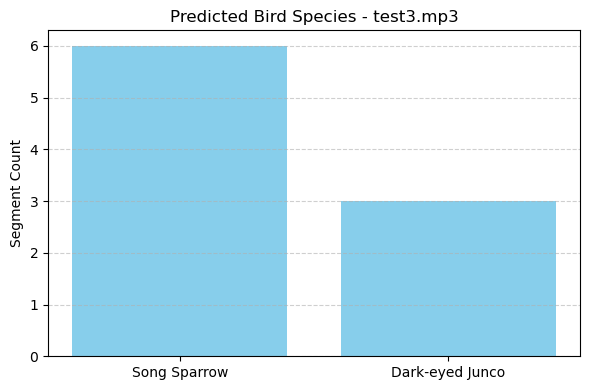

In [33]:
# Test MP3 File Paths
test_files = [
    "/Users/rich/Downloads/test1.mp3",
    "/Users/rich/Downloads/test2.mp3",
    "/Users/rich/Downloads/test3.mp3"]

# Mapping Labels 
species_fullnames = {
    'amecro': 'American Crow',
    'amerob': 'American Robin',
    'bewwre': "Bewick’s Wren",
    'bkcchi': 'Black-capped Chickadee',
    'daejun': 'Dark-eyed Junco',
    'houfin': 'House Finch',
    'houspa': 'House Sparrow',
    'norfli': 'Northern Flicker',
    'rewbla': 'Red-winged Blackbird',
    'sonspa': 'Song Sparrow',
    'spotow': 'Spotted Towhee',
    'whcspa': 'White-crowned Sparrow'
}

# Spectrogram Extraction Function
def extract_spectrogram(filepath, start_sec=0, total_sec=6.0, stride=0.5, sr=22050):
    y, _ = librosa.load(filepath, sr=sr, offset=start_sec, duration=total_sec)
    window_size = int(2 * sr)
    step_size = int(stride * sr)
    spectrograms = []

    for start in range(0, len(y) - window_size + 1, step_size):
        y_seg = y[start:start + window_size]
        S = librosa.feature.melspectrogram(y=y_seg, sr=sr, n_mels=128, hop_length=128, win_length=512)
        S_db = librosa.power_to_db(S, ref=np.max)
        S_db = librosa.util.fix_length(S_db, size=517, axis=1)
        max_val = np.max(S_db)
        S_db = S_db / max_val if max_val > 0 else np.zeros_like(S_db)
        S_db = S_db[..., np.newaxis]  # shape: (128, 517, 1)
        spectrograms.append(S_db)

    return np.array(spectrograms)

# Prediction and Plotting
def predict_and_plot(filepath, model, label_encoder, start_sec=0, total_sec=6.0):
    specs = extract_spectrogram(filepath, start_sec, total_sec)
    if specs.shape[0] == 0:
        print(f"{os.path.basename(filepath)}: no valid segments found.")
        return

    preds = model.predict(specs)
    pred_classes = np.argmax(preds, axis=1)
    pred_labels = label_encoder.inverse_transform(pred_classes)
    summary = Counter(pred_labels)

    # Map to full species names
    full_summary = {species_fullnames.get(k, k): v for k, v in summary.items()}

    # Print Prediction
    print(f"{os.path.basename(filepath)}: Predicted species: {list(full_summary.keys())}")
    if len(full_summary) > 1:
        print("Multiple species likely present.")
    else:
        print("Single species likely present.")

    # Plot
    plt.figure(figsize=(6, 4))
    plt.bar(full_summary.keys(), full_summary.values(), color='skyblue')
    plt.title(f"Predicted Bird Species - {os.path.basename(filepath)}")
    plt.ylabel("Segment Count")
    plt.xticks(rotation=0, ha='center') 
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

# Predict and Plot
for file in test_files:
    predict_and_plot(file, model_multiclass_full1, label_encoder)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step


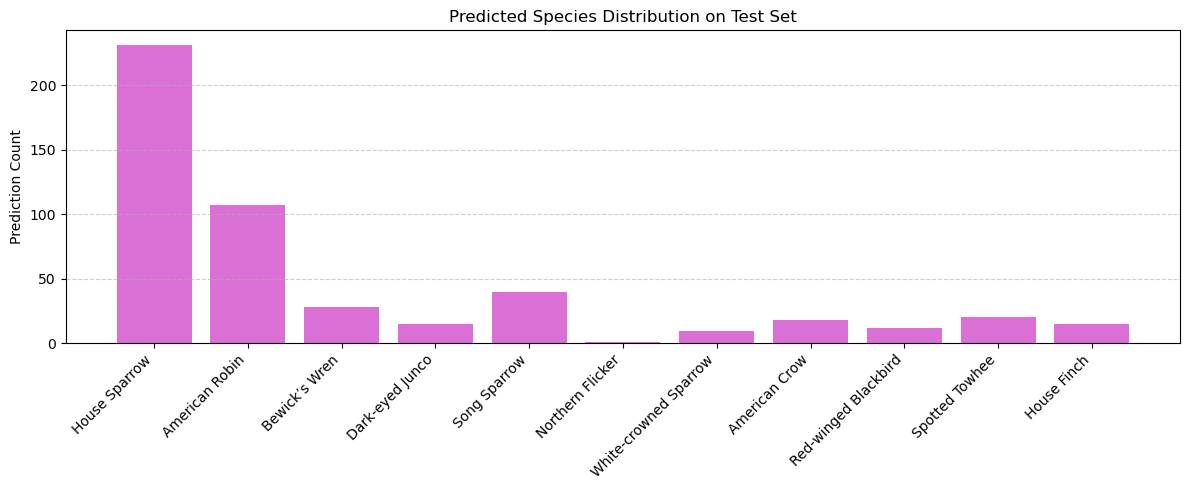

In [37]:
# Run model on all test spectrograms
y_pred_probs = model_multiclass_full1.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Count predicted class frequency
pred_counts = Counter(label_encoder.inverse_transform(y_pred))
true_counts = Counter(label_encoder.inverse_transform(y_true))

# Plot
labels = [species_fullnames[k] for k in pred_counts.keys()]
pred_vals = list(pred_counts.values())

plt.figure(figsize=(12, 5))
plt.bar(labels, pred_vals, color='orchid')
plt.title("Predicted Species Distribution on Test Set")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Prediction Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()